# 1. Load & Inspect Dataset

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/Sepsis Prediction.csv")

print(df.info())
display(df.head())

print("\nTarget distribution:")
print(df["SepsisLabel"].value_counts())
print(df["SepsisLabel"].value_counts(normalize=True))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 44 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1552210 non-null  int64  
 1   Hour              1552210 non-null  int64  
 2   HR                1398811 non-null  float64
 3   O2Sat             1349474 non-null  float64
 4   Temp              525226 non-null   float64
 5   SBP               1325945 non-null  float64
 6   MAP               1358940 non-null  float64
 7   DBP               1065656 non-null  float64
 8   Resp              1313875 non-null  float64
 9   EtCO2             57636 non-null    float64
 10  BaseExcess        84145 non-null    float64
 11  HCO3              65028 non-null    float64
 12  FiO2              129365 non-null   float64
 13  pH                107573 non-null   float64
 14  PaCO2             86301 non-null    float64
 15  SaO2              53561 non-null    float64
 16  

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072



Target distribution:
SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64
SepsisLabel
0    0.982015
1    0.017985
Name: proportion, dtype: float64


#2. Basic Cleaning & Separation

In [2]:
df = df.drop(columns=["Unnamed: 0", "EtCO2"])

y = df["SepsisLabel"]
patient_ids = df["Patient_ID"]

X = df.drop(columns=["SepsisLabel", "Patient_ID"])



#3. Patient-Level Feature Aggregation

In [3]:
df_model = X.copy()
df_model["SepsisLabel"] = y
df_model["Patient_ID"] = patient_ids

agg_funcs = ["mean", "max", "min"]

patient_features = (
    df_model
    .groupby("Patient_ID")
    .agg({col: agg_funcs for col in X.columns})
)

patient_features.columns = [
    f"{col}_{stat}" for col, stat in patient_features.columns
]

patient_labels = (
    df_model
    .groupby("Patient_ID")["SepsisLabel"]
    .max()
)

X_patient = patient_features
y_patient = patient_labels

print(X_patient.shape)
print(y_patient.value_counts(normalize=True))


(40336, 120)
SepsisLabel
0    0.927311
1    0.072689
Name: proportion, dtype: float64


#4. Patient-Level Train/Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_patient,
    y_patient,
    test_size=0.25,
    stratify=y_patient,
    random_state=42
)


#5. Missingness Indicators + Imputation

In [5]:
from sklearn.impute import SimpleImputer

# Missing indicators (vectorised, no fragmentation)
X_train_missing = X_train.isna().astype(int)
X_test_missing = X_test.isna().astype(int)

X_train_missing.columns = [c + "_missing" for c in X_train.columns]
X_test_missing.columns = [c + "_missing" for c in X_test.columns]

# Median imputation
imputer = SimpleImputer(strategy="median")

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imp = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Final matrices
X_train_final = pd.concat([X_train_imp, X_train_missing], axis=1)
X_test_final = pd.concat([X_test_imp, X_test_missing], axis=1)

print(X_train_final.shape, X_test_final.shape)
print("NaN left:", X_train_final.isna().any().any())



(30252, 240) (10084, 240)
NaN left: False


# Baseline Model

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train_final, y_train)

y_test_prob = log_reg.predict_proba(X_test_final)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, (y_test_prob >= 0.5).astype(int)))


ROC-AUC: 0.8420028761578711
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9351
           1       0.22      0.77      0.34       733

    accuracy                           0.78     10084
   macro avg       0.60      0.77      0.60     10084
weighted avg       0.92      0.78      0.83     10084



# 7. Threshold Tuning

In [7]:
from sklearn.metrics import recall_score, precision_score

for t in np.arange(0.1, 0.51, 0.05):
    preds = (y_test_prob >= t).astype(int)
    print(
        f"t={t:.2f}",
        "recall:", recall_score(y_test, preds),
        "precision:", precision_score(y_test, preds)
    )



t=0.10 recall: 0.984993178717599 precision: 0.0818130311614731
t=0.15 recall: 0.9672578444747613 precision: 0.09359735973597359
t=0.20 recall: 0.9454297407912687 precision: 0.10653343581860107
t=0.25 recall: 0.9181446111869032 precision: 0.1197508896797153
t=0.30 recall: 0.8908594815825375 precision: 0.1348616274266832
t=0.35 recall: 0.8703956343792633 precision: 0.15373493975903615
t=0.40 recall: 0.8321964529331515 precision: 0.17163759144625773
t=0.45 recall: 0.7953615279672579 precision: 0.19247276328821394
t=0.50 recall: 0.7667121418826739 precision: 0.21707222865971418


#8. XGBoost (Final Model)

In [9]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_model.fit(X_train_final, y_train)

y_test_prob = xgb_model.predict_proba(X_test_final)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))

threshold = 0.30
final_preds = (y_test_prob >= threshold).astype(int)

print(classification_report(y_test, final_preds))


ROC-AUC: 0.9398538111134309
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      9351
           1       0.36      0.84      0.50       733

    accuracy                           0.88     10084
   macro avg       0.67      0.86      0.72     10084
weighted avg       0.94      0.88      0.90     10084



# 9. SHAP Explainability

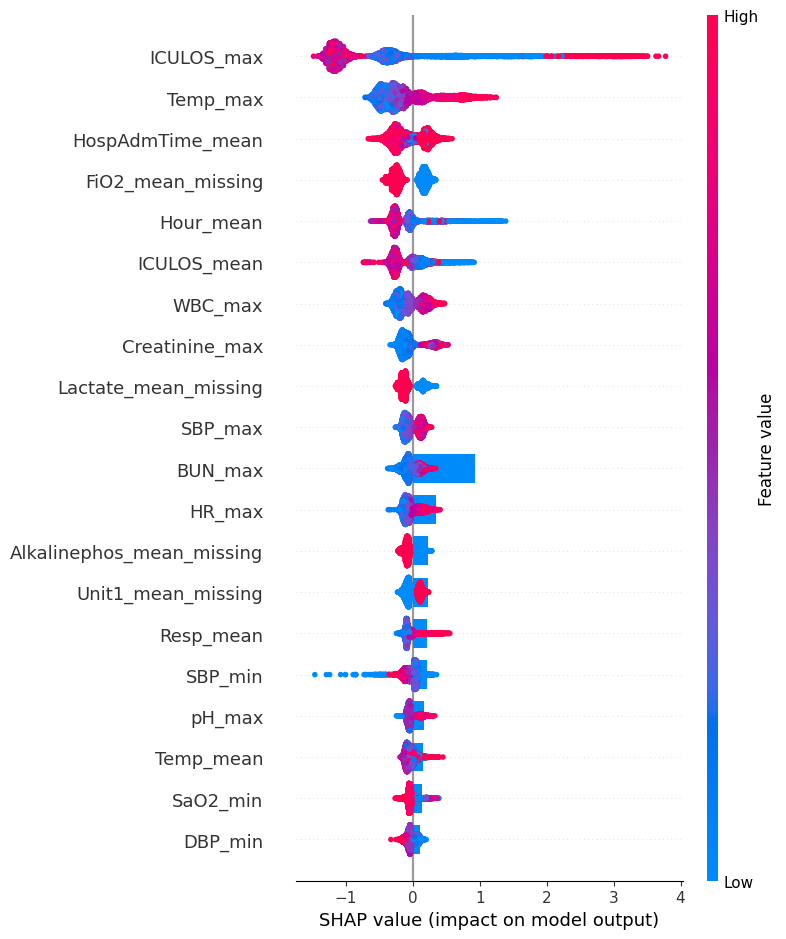

In [10]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_final)

shap.summary_plot(
    shap_values,
    X_test_final,
    plot_type="bar",
    max_display=10,
    show=False
)
plt.savefig("shap_bar.png", bbox_inches="tight")

shap.summary_plot(
    shap_values,
    X_test_final,
    show=False
)
plt.savefig("shap_beeswarm.png", bbox_inches="tight")
